## 1 - Test avec RandomForest

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(f"./Driving_Behavior_Dataset/sensor_raw.csv")

X = data.drop("Target(Class)", axis=1)
Y = data["Target(Class)"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       0.69      0.50      0.58        50
           2       0.69      0.64      0.66        58
           3       0.62      0.81      0.70        70
           4       0.83      0.76      0.79        45

    accuracy                           0.69       223
   macro avg       0.71      0.68      0.68       223
weighted avg       0.70      0.69      0.68       223



In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv")

X = data.drop("Target", axis=1)
Y = data["Target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        70
           4       1.00      1.00      1.00        44

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



--- Début de l'optimisation par Window Size ---


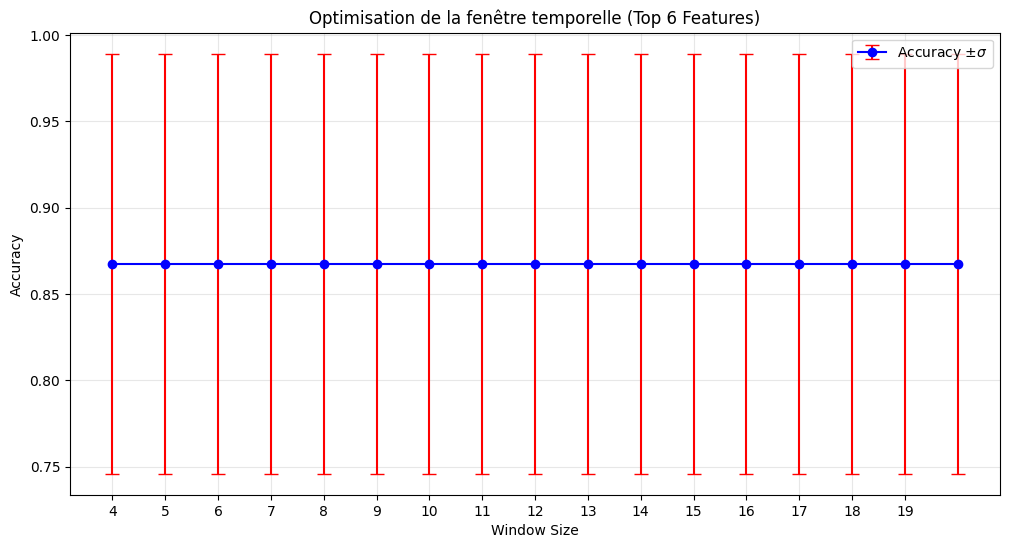

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Variables de stockage
window_sizes = []
mean_scores = []
std_scores = []

selected_features = ['GyroMeanZ', 'GyroSumZ', 'GyroStdZ', 'GyroMinZ', 'GyroMaxZ', 'AccVarY']

print("--- Début de l'optimisation par Window Size ---")

for i in range(4, 21):
    try:
        # 1. Chargement forcé du fichier courant
        path = f"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_{i}.csv"
        data_current = pd.read_csv(path)
        
        # VERIFICATION : On affiche la taille pour être sûr que les fichiers diffèrent

        # 2. Extraction des features et de la cible pour CE fichier uniquement
        X_current = data_current[selected_features]
        y_current = data_current["Target"]

        # 3. Réinitialisation du classifieur à chaque tour
        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

        # 4. Cross-Validation (5-Fold)
        scores = cross_val_score(clf, X_current, y_current, cv=5)

        # 5. Stockage
        window_sizes.append(i)
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())

    except Exception as e:
        print(f"Erreur sur le fichier {i} : {e}")

# --- Affichage du Graphique Correctif ---
plt.figure(figsize=(12, 6))
plt.errorbar(window_sizes, mean_scores, yerr=std_scores, fmt='-o', 
             capsize=5, ecolor='red', color='blue', label=r'Accuracy $\pm \sigma$')

plt.title("Optimisation de la fenêtre temporelle (Top 6 Features)")
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.xticks(range(4, 20))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Calcul en cours...


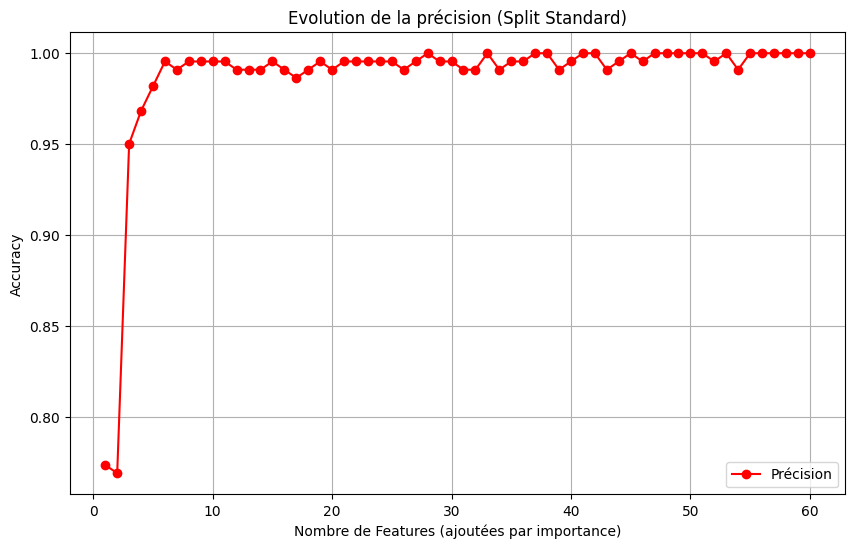

Top 5 des variables les plus influentes :
['GyroMeanZ', 'GyroSumZ', 'GyroMinZ', 'GyroStdZ', 'GyroMaxZ']


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# 1. Chargement des données 
df = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv") 

# 2. Importation Importances 
model = RandomForestClassifier(n_estimators=200, random_state=42)
X = df.drop("Target", axis=1)
y = df["Target"]
model.fit(X, y)
importances = model.feature_importances_

# 3. Préparation des Features triées
feature_names = df.drop("Target", axis=1).columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# On trie du plus important au moins important
sorted_features = feat_imp_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()

# 4. Split Classique 
X = df.drop("Target", axis=1)
y = df["Target"]

# On utilise le split standard avec shuffle (ce qui donne les 100%)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. La Boucle d'Optimisation
accuracies = []
nums = []

print("Calcul en cours...")
for k in range(1, len(sorted_features) + 1):
    # On prend les k meilleures colonnes
    top_k_features = sorted_features[:k]
    
    # On réduit le train/test à ces colonnes
    X_train_k = X_train_full[top_k_features]
    X_test_k = X_test_full[top_k_features]
    
    # Entraînement rapide
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X_train_k, y_train)
    
    # Score
    acc = accuracy_score(y_test, clf.predict(X_test_k))
    accuracies.append(acc)
    nums.append(k)

# 6. Graphique
plt.figure(figsize=(10, 6))
plt.plot(nums, accuracies, marker='o', color='red', label='Précision')
plt.title("Evolution de la précision (Split Standard)")
plt.xlabel("Nombre de Features (ajoutées par importance)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Affichage du top 5
print("Top 5 des variables les plus influentes :")
print(sorted_features[:5])

Calcul de la Cross-Validation pour chaque subset...


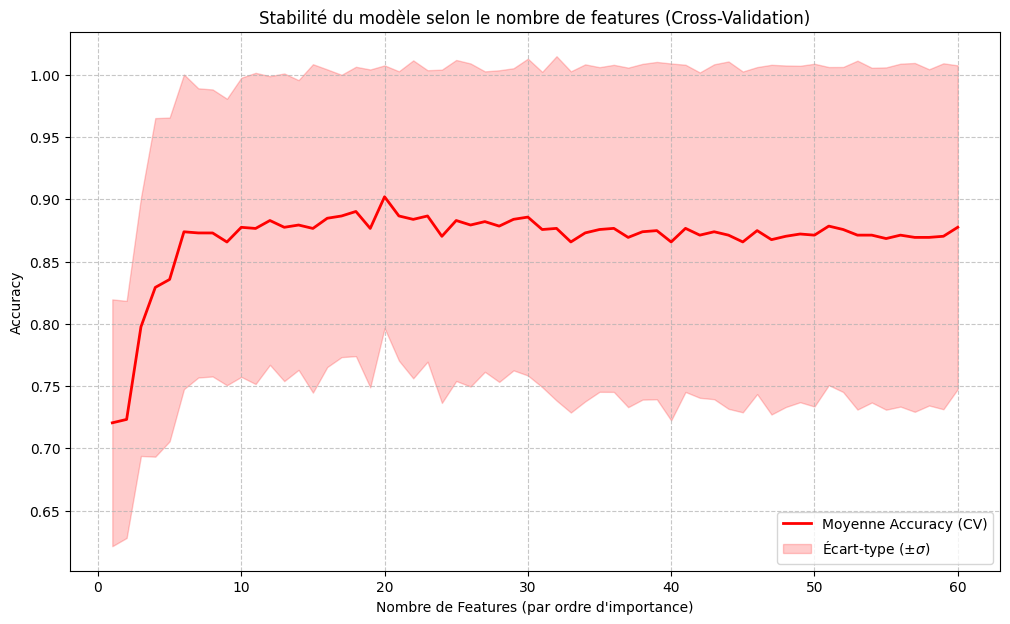

Top 10 des features : ['GyroMeanZ', 'GyroSumZ', 'GyroStdZ', 'GyroMinZ', 'GyroMaxZ', 'AccVarY', 'AccMinY', 'AccMaxY', 'GyroCovZ', 'AccCovX']


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# 1. Chargement et calcul des importances (comme précédemment)
df = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv") 
X = df.drop("Target", axis=1)
y = df["Target"]

model_imp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_imp.fit(X, y)

feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': model_imp.feature_importances_})
sorted_features = feat_imp_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()

# 2. Boucle d'optimisation avec Cross-Validation
cv_means = []
cv_stds = []
nums = range(1, len(sorted_features) + 1)

print("Calcul de la Cross-Validation pour chaque subset...")
for k in nums:
    top_k_features = sorted_features[:k]
    X_k = X[top_k_features]
    
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    
    # Calcul des scores sur 5 plis (folds)
    scores = cross_val_score(clf, X_k, y, cv=5, scoring='accuracy')
    
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

# Conversion en tableaux numpy pour faciliter les calculs du graphe
cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

# 3. Graphique avec zone d'incertitude
plt.figure(figsize=(12, 7))

# Courbe de la moyenne
plt.plot(nums, cv_means, color='red', lw=2, label='Moyenne Accuracy (CV)')

plt.fill_between(nums, 
                 cv_means - cv_stds, 
                 cv_means + cv_stds, 
                 color='red', alpha=0.2, label=r'Écart-type ($\pm \sigma$)')

plt.title("Stabilité du modèle selon le nombre de features (Cross-Validation)")
plt.xlabel("Nombre de Features (par ordre d'importance)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()


print(f"Top 10 des features : {sorted_features[:10]}")

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv")

X = data[['GyroMeanZ', 'GyroSumZ', 'GyroMinZ', 'GyroStdZ', 'AccMaxY']]
Y = data["Target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        57
           3       1.00      0.99      0.99        70
           4       1.00      1.00      1.00        44

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



## 2 - Test avec d'autres Models

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(f"./Driving_Behavior_Dataset/sensor_raw.csv")

X = data.drop("Target(Class)", axis=1)
Y = data["Target(Class)"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

models = {
    "SVM": SVC(kernel='rbf', C=1.0, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Regression": LogisticRegression(max_iter=1000),
    "RNN": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500)
          }

for name, model in models.items() :
    model.fit(X_train, Y_train)

    Y_Pred = model.predict(X_test)

    print(name, classification_report(Y_test, Y_Pred))

SVM               precision    recall  f1-score   support

           1       0.46      0.12      0.19        50
           2       0.96      0.38      0.54        58
           3       0.47      0.70      0.56        70
           4       0.35      0.64      0.46        45

    accuracy                           0.48       223
   macro avg       0.56      0.46      0.44       223
weighted avg       0.57      0.48      0.45       223

KNN               precision    recall  f1-score   support

           1       0.40      0.48      0.44        50
           2       0.61      0.59      0.60        58
           3       0.53      0.57      0.55        70
           4       0.61      0.42      0.50        45

    accuracy                           0.52       223
   macro avg       0.54      0.51      0.52       223
weighted avg       0.54      0.52      0.53       223

Regression               precision    recall  f1-score   support

           1       0.34      0.28      0.31        50
  

/Users/ap/Library/Mobile Documents/com~apple~CloudDocs/Estaca/4A/SEMESTRE_2/IA/ProjetIA_Driver_Risk/.env/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

data = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv")

X = data.drop("Target", axis=1)
Y = data["Target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

models = {
    "SVM": SVC(kernel='rbf', C=1.0, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Regression": LogisticRegression(max_iter=2000),
    "RNN": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500)
          }

for name, model in models.items() :
    model.fit(X_train, Y_train)

    Y_Pred = model.predict(X_test)

    print(name, classification_report(Y_test, Y_Pred))

SVM               precision    recall  f1-score   support

           1       0.76      0.84      0.80        50
           2       1.00      0.96      0.98        57
           3       1.00      0.84      0.91        70
           4       0.73      0.86      0.79        44

    accuracy                           0.88       221
   macro avg       0.87      0.88      0.87       221
weighted avg       0.89      0.88      0.88       221

KNN               precision    recall  f1-score   support

           1       0.98      1.00      0.99        50
           2       1.00      0.98      0.99        57
           3       1.00      0.99      0.99        70
           4       0.98      1.00      0.99        44

    accuracy                           0.99       221
   macro avg       0.99      0.99      0.99       221
weighted avg       0.99      0.99      0.99       221

Regression               precision    recall  f1-score   support

           1       0.98      0.94      0.96        50
  

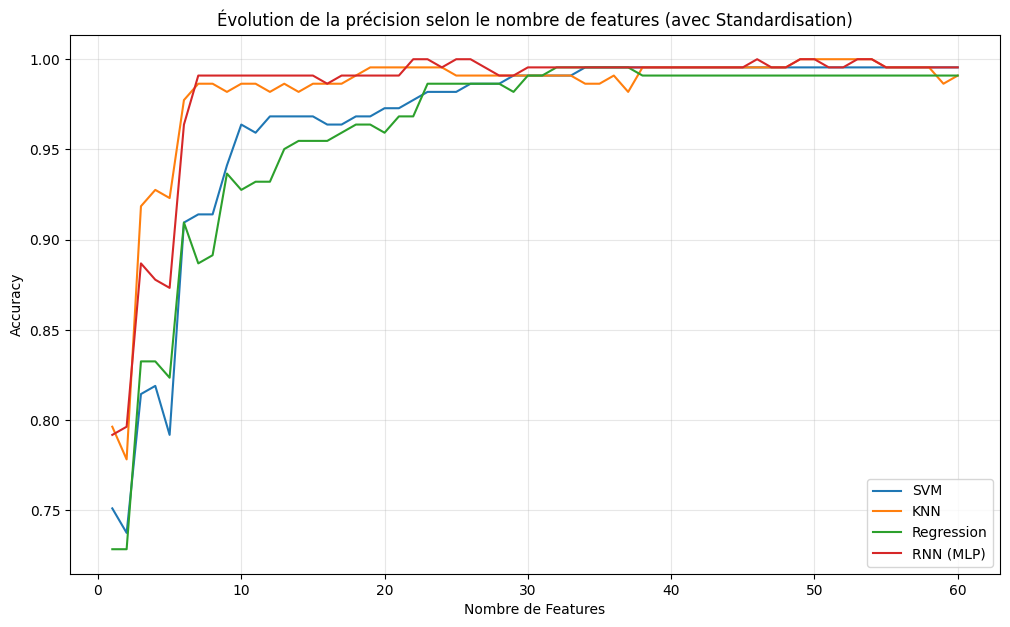

Top 5 des variables les plus influentes :
['GyroMeanZ', 'GyroSumZ', 'GyroMinZ', 'GyroStdZ', 'GyroMaxZ']


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler # <--- Crucial

# 1. Chargement des données
df = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv") 

# 2. Importance des features (Random Forest n'a pas besoin de scaling)
X = df.drop("Target", axis=1)
y = df["Target"]
rf_selector = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_selector.fit(X, y)
sorted_features = pd.DataFrame({'F': X.columns, 'I': rf_selector.feature_importances_}) \
                    .sort_values(by='I', ascending=False)['F'].tolist()

# 3. Split
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Modèles
models = {
    "SVM": SVC(kernel='rbf', C=1.0, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Regression": LogisticRegression(max_iter=1000),
    "RNN (MLP)": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=2000, random_state=42)
}

# 5. Boucle avec Scaling
plt.figure(figsize=(12, 7))

for model_name, clf in models.items():
    accuracies = []
    nums = []
    
    for k in range(1, len(sorted_features) + 1):
        top_k_features = sorted_features[:k]
        X_tr = X_train_full[top_k_features]
        X_te = X_test_full[top_k_features]
        
        # --- Étape de Scaling ---
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_te_scaled = scaler.transform(X_te)
        
        clf.fit(X_tr_scaled, y_train)
        acc = accuracy_score(y_test, clf.predict(X_te_scaled))
        
        accuracies.append(acc)
        nums.append(k)
    
    plt.plot(nums, accuracies, label=model_name)

plt.title("Évolution de la précision selon le nombre de features (avec Standardisation)")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Affichage du top 5
print("Top 5 des variables les plus influentes :")
print(sorted_features[:5])

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


# 1. Chargement et sélection des features
data = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv")

# Utilisation de la sélection spécifique
features = ['GyroMeanZ', 'GyroSumZ', 'GyroStdZ', 'GyroMinZ', 'GyroMaxZ', 'AccVarY']
X = data[features]
Y = data["Target"]

# 2. Split avec stratification
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# 3. Standardisation (Indispensable pour SVM, Regression et MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Définition du dictionnaire de modèles
models = {
    "Random Forest Classifier": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVC": SVC(kernel='linear', C=1.0, random_state=42),
    "Regression": LogisticRegression(max_iter=2000),
    "RNN (MLPC)": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000,  random_state=42)
}

# 5. Entraînement et Évaluation
for name, model in models.items():
    print(f"--- Évaluation : {name} ---")
    
    # Validation Croisée (K-Fold, cv=5)
    cv_scores = cross_val_score(model, X_train_scaled, Y_train, cv=5)
    
    # Entraînement final pour le rapport de classification
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)
    
    # Affichage des résultats
    print(f"CV Accuracy Moyenne : {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print("\nRapport de Classification (sur Test Set) :")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

--- Évaluation : Random Forest Classifier ---
CV Accuracy Moyenne : 0.9830 (+/- 0.0203)

Rapport de Classification (sur Test Set) :
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        57
           3       1.00      0.99      0.99        70
           4       1.00      1.00      1.00        44

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221

--------------------------------------------------
--- Évaluation : SVC ---
CV Accuracy Moyenne : 0.8933 (+/- 0.0540)

Rapport de Classification (sur Test Set) :
              precision    recall  f1-score   support

           1       0.66      1.00      0.79        50
           2       1.00      0.98      0.99        57
           3       1.00      0.86      0.92        70
           4       1.00      0.66      0.79        44


In [25]:
from sklearn.model_selection import GridSearchCV

# 1. Définition des grilles de paramètres 
param_grids = {
    "Random Forest Classifier": {
        "n_estimators": [100, 200, 500, 1000], 
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10],
    },
    "SVC": {
        "C": [1, 10, 100],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    },
    "Regression": {
        "C": [0.1, 1, 10, 100],
        "solver": ['lbfgs', 'saga'], 
    },
    "RNN (MLPC)": {
        "hidden_layer_sizes": [(64,32),(128, 64), (256, 128), (32,64,128), (64,128,256)],
        "alpha": [0.0001, 0.001],
        "activation": ['relu', 'logistic', 'identity', 'tanh'],
        "learning_rate_init": [0.001, 0.01], 
        "max_iter": [2000] 
    }
}

# 2. Exécution de la recherche sur les données déjà scalées
best_models = {}

for name, model in models.items():
    print(f"--- Optimisation : {name} ---")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # On utilise ici les données scalées globalement
    grid_search.fit(X_train_scaled, Y_train)
    
    best_models[name] = grid_search.best_estimator_
    
    print(f"Meilleurs paramètres : {grid_search.best_params_}")
    print(f"Meilleur score CV : {grid_search.best_score_:.4f}")
    
    # Évaluation sur le test set (également scalé)
    Y_pred = grid_search.predict(X_test_scaled)
    print("\nRapport de Classification :")
    print(classification_report(Y_test, Y_pred))
    print("-" * 50)

--- Optimisation : Random Forest Classifier ---
Meilleurs paramètres : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}
Meilleur score CV : 0.9853

Rapport de Classification :
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        57
           3       1.00      0.99      0.99        70
           4       1.00      1.00      1.00        44

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221

--------------------------------------------------
--- Optimisation : SVC ---
Meilleurs paramètres : {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Meilleur score CV : 0.9285

Rapport de Classification :
              precision    recall  f1-score   support

           1       0.85      1.00      0.92        50
           2       1.00      1.00      1.00        57
      